In [65]:
#importing packages and getting a sense of the data
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, confint_proportions_2indep
from statsmodels.sandbox.stats.multicomp import multipletests
df = pd.read_csv('abtesting.csv', parse_dates=['join_dt', 'dt'])
print(df.head())
print(df.info())

        id group    join_dt country gender device  dt  spent
0  1000000     B 2023-01-28     CAN      M      I NaT    NaN
1  1000001     A 2023-01-27     BRA      M      A NaT    NaN
2  1000002     A 2023-02-01     FRA      M      A NaT    NaN
3  1000003     B 2023-01-25     BRA      M      I NaT    NaN
4  1000004     A 2023-02-04     DEU      F      A NaT    NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49082 entries, 0 to 49081
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       49082 non-null  int64         
 1   group    49082 non-null  object        
 2   join_dt  49082 non-null  datetime64[ns]
 3   country  48435 non-null  object        
 4   gender   42200 non-null  object        
 5   device   48787 non-null  object        
 6   dt       2233 non-null   datetime64[ns]
 7   spent    2233 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 3.0

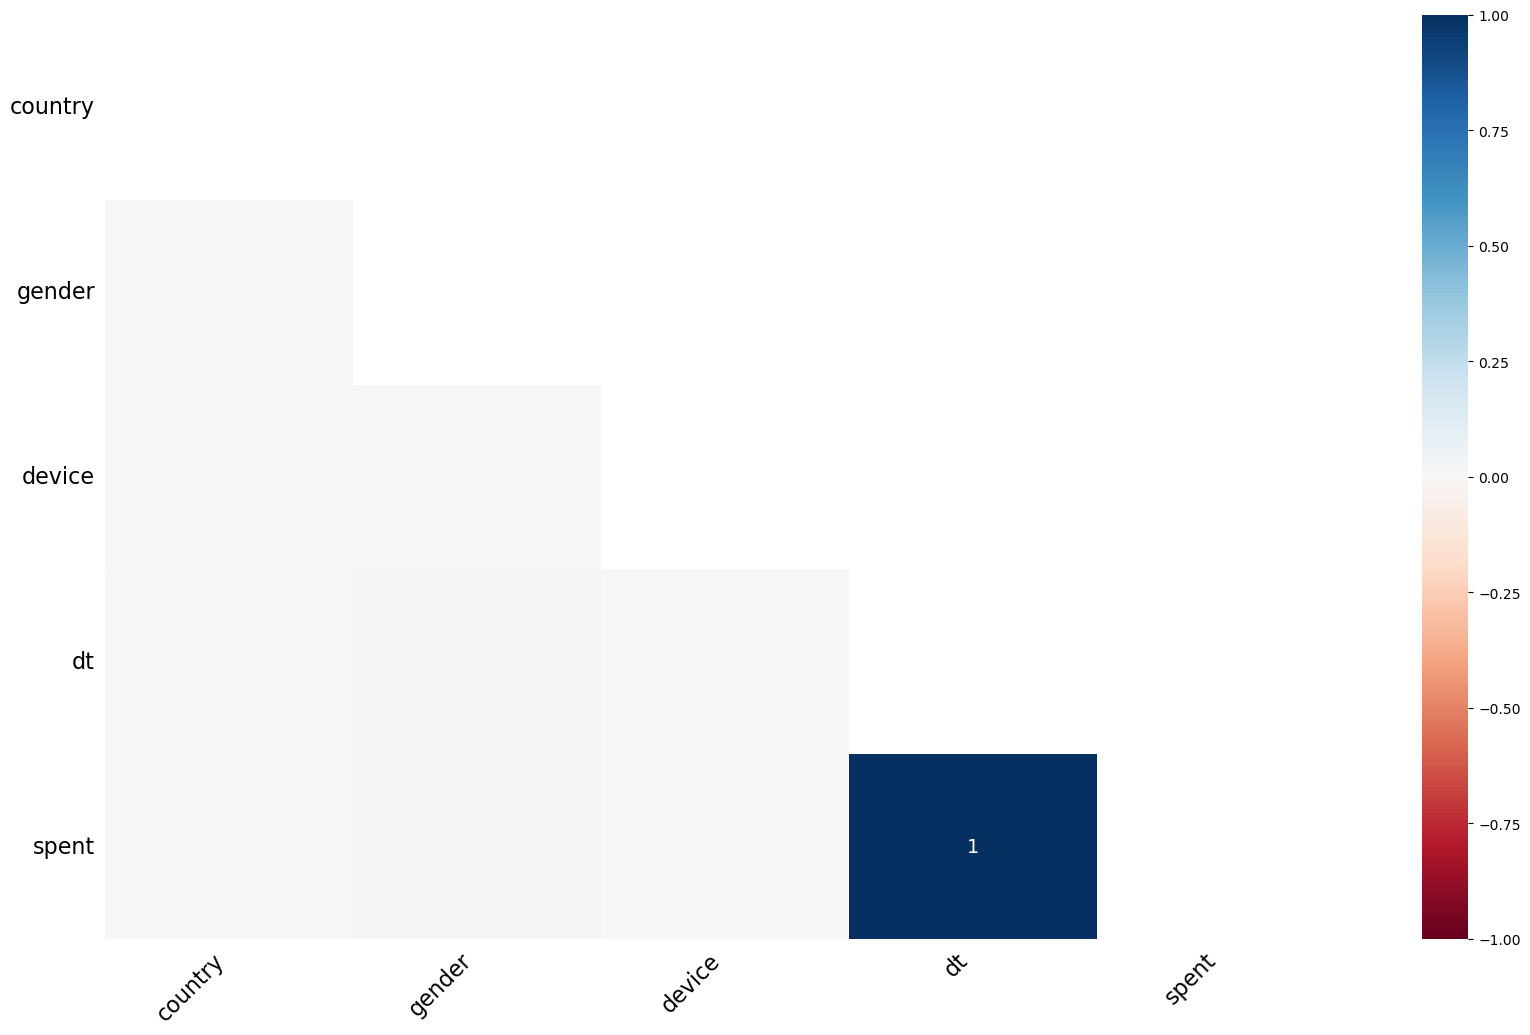

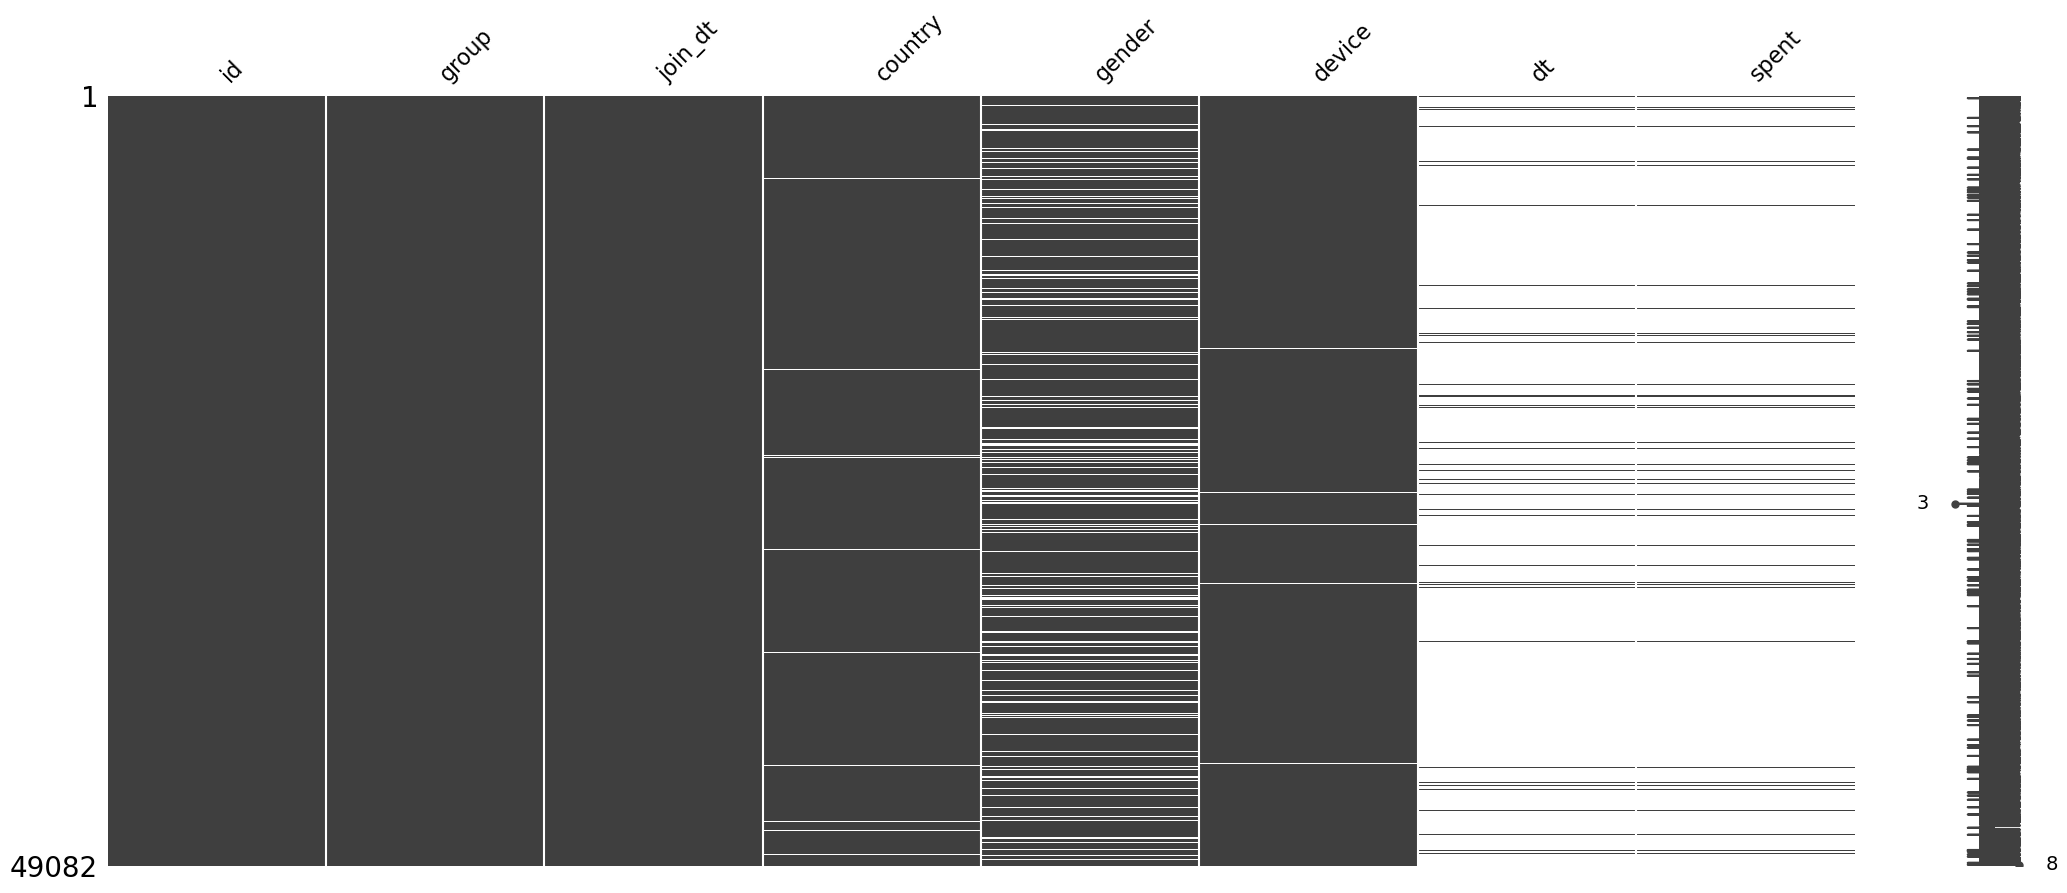

In [66]:
#checking for correlation amongst missing values and with other variables
msno.heatmap(df)
msno.matrix(df.sort_values('join_dt'))
plt.show()

In [67]:
#replacing nulls
df[['country', 'gender', 'device']] = df[['country', 'gender', 'device']].fillna('None')

In [68]:
#totalling spent by unique id and dropping duplicates
temp = df.groupby('id')['spent'].sum().to_frame().reset_index()
byid = df.merge(temp,on='id', suffixes=('_left', None))
byid = byid.drop(['spent_left'], axis=1 )
byid = byid.drop_duplicates(subset=['id', 'spent'])
byid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48943 entries, 0 to 49081
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       48943 non-null  int64         
 1   group    48943 non-null  object        
 2   join_dt  48943 non-null  datetime64[ns]
 3   country  48943 non-null  object        
 4   gender   48943 non-null  object        
 5   device   48943 non-null  object        
 6   dt       2094 non-null   datetime64[ns]
 7   spent    48943 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 3.4+ MB


In [69]:
#checking if values and observations are equally split between control and treatment group
print(byid.group.value_counts())
print(byid.groupby('group')['country'].value_counts())
print(byid.groupby('group')['gender'].value_counts())
print(byid.groupby('group')['device'].value_counts())

B    24600
A    24343
Name: group, dtype: int64
group  country
A      USA        7309
       BRA        4805
       MEX        2815
       DEU        1906
       TUR        1849
       FRA        1536
       GBR        1455
       ESP         997
       CAN         767
       AUS         608
       None        296
B      USA        7463
       BRA        4629
       MEX        2923
       DEU        1948
       TUR        1883
       FRA        1554
       GBR        1494
       ESP         996
       CAN         803
       AUS         560
       None        347
Name: country, dtype: int64
group  gender
A      F         10069
       M         10054
       None       3412
       O           808
B      M         10235
       F         10061
       None       3443
       O           861
Name: gender, dtype: int64
group  device
A      A         15054
       I          9142
       None        147
B      A         15235
       I          9218
       None        147
Name: device, dtype: int64

In [70]:
#mean spent by group
byid.groupby('group')['spent'].mean()


group
A    3.374518
B    3.390867
Name: spent, dtype: float64

In [71]:
#testing for statistically significant difference between spent means
control = byid[byid['group']=='A']
treatment = byid[byid['group']=='B']
statistic, spent_pvalue= ttest_ind(control['spent'], treatment['spent'])
print(statistic, spent_pvalue)

-0.07043243220818624 0.9438497659410893


In [72]:
#testing for statistically significant difference in conversion rates
counts_array = np.array(byid[byid['spent']>0].groupby('group')['id'].count())
nobs_array = np.array(byid.groupby('group')['id'].count())
conv_rates = counts_array/nobs_array
z_score, conv_p_value = proportions_ztest(counts_array, nobs_array, alternative='smaller')
print('Conversion rate for A and B', conv_rates)
print('z_score =', z_score, 'p_value =', conv_p_value)

Conversion rate for A and B [0.03923099 0.04630081]
z_score = -3.864291770414927 p_value = 5.570599266473543e-05


In [73]:
#confidence intervals for the conversion rates and their difference
lower, upper = proportion_confint(counts_array, nobs_array, 0.05)
diff_lower, diff_upper = confint_proportions_2indep(counts_array[1], nobs_array[1],
                                                    counts_array[0], nobs_array[0],
                                                    alpha= 0.05)
percnt_lower, percnt_upper = confint_proportions_2indep(counts_array[1], nobs_array[1],
                                                    counts_array[0], nobs_array[0],
                                                    alpha= 0.05, compare= 'ratio')
print(lower, upper)
print('difference conf interval:', diff_lower, diff_upper)
print('percent increase interval:', percnt_lower, percnt_upper)

[0.03679214 0.0436749 ] [0.04166984 0.04892673]
difference conf interval: 0.003485883638388947 0.01065861062894547
percent increase interval: 1.084891287374649 1.283687242539135


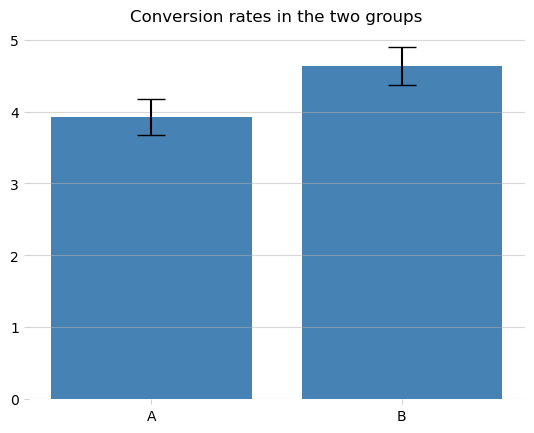

In [74]:
#plotting the conversion rates
errors = [conv_rates-lower, upper-conv_rates]
ticks = np.arange(6)

fig, ax = plt.subplots()
ax.bar(x=['A','B'],height= conv_rates, 
       yerr=errors, capsize = 10, color='steelblue')
ax.set_title('Conversion rates in the two groups')
ax.set_yticks(np.arange(0, 0.06, 0.01), ticks)
ax.tick_params(grid_alpha = 0.5, color= 'lightgrey')
ax.yaxis.grid(True)
ax.set_frame_on(b=False)
plt.show()

In [75]:
#drill down on conversion rate by gender
byid[byid['spent']>0].groupby(['group', 'gender'])['id'].count() / byid.groupby(['group', 'gender'])['id'].count()

group  gender
A      F         0.051445
       M         0.026258
       None      0.043083
       O         0.032178
B      F         0.054368
       M         0.037909
       None      0.051699
       O         0.030197
Name: id, dtype: float64

In [76]:
#testing for statistical significance in men conversion rate
counts_array = np.array(byid[(byid['spent']>0) & (byid['gender']=='M')].groupby(['group','gender'])['id'].count())
nobs_array = np.array(byid[byid['gender']=='M'].groupby(['group', 'gender'])['id'].count())
z_score, men_conv_p_value = proportions_ztest(counts_array, nobs_array, alternative='smaller')
conv_rates = counts_array/nobs_array
print("Men's conversion rates:" , conv_rates)
print('z_score =', z_score, 'p_value =', men_conv_p_value)

Men's conversion rates: [0.02625821 0.03790914]
z_score = -4.704818740508377 p_value = 1.2704580129669962e-06


In [77]:
#confidence intervals for men's conversion rates and their difference
lower, upper = proportion_confint(counts_array, nobs_array, 0.05)
diff_lower, diff_upper = confint_proportions_2indep(counts_array[1], nobs_array[1],
                                                    counts_array[0], nobs_array[0],
                                                    alpha= 0.05)
percnt_lower, percnt_upper = confint_proportions_2indep(counts_array[1], nobs_array[1],
                                                    counts_array[0], nobs_array[0],
                                                    alpha= 0.05, compare= 'ratio')
print(lower, upper)
print('difference conf interval:', diff_lower, diff_upper)
print('percent increase interval:', percnt_lower, percnt_upper)

[0.02313261 0.03420929] [0.0293838  0.04160899]
difference conf interval: 0.00681112655254565 0.0165218907828372
percent increase interval: 1.2371514071506908 1.6827154092315604


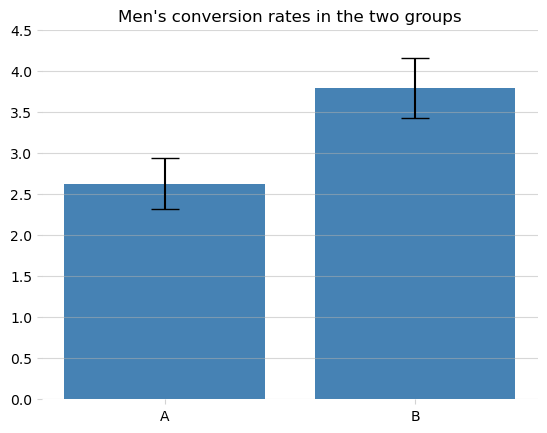

In [78]:
#plotting the conversion rates
errors = [conv_rates-lower, upper-conv_rates]
ticks2 = np.arange(5, step=0.5)

fig, ax = plt.subplots()
ax.bar(x=['A','B'],height= conv_rates, 
       yerr=errors, capsize = 10, color='steelblue')
ax.set_title("Men's conversion rates in the two groups")
ax.set_yticks(np.arange(0, 0.05, 0.005), ticks2)
ax.tick_params(grid_alpha = 0.5, color= 'lightgrey')
ax.yaxis.grid(True)
ax.set_frame_on(b=False)
plt.show()

In [83]:
#checking the average length of time between joining and first purchase in the two groups
time = byid
time['datediff']= byid['dt']-byid['join_dt']
time = time[time['datediff'].notnull()]
time['inhours'] = time['datediff']/pd.to_timedelta(1, 'h')
time.groupby('group')['inhours'].mean()


/var/folders/qt/64bcd8c16svddhthwk6tzgq80000gn/T/ipykernel_5852/4062909385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['inhours'] = time['datediff']/pd.to_timedelta(1, 'h')


group
A    18.898429
B    17.952590
Name: inhours, dtype: float64

In [84]:
time_filtered


,id,group,join_dt,country,gender,device,dt,spent,datediff,inhours
38,1000039,B,2023-02-04,GBR,F,A,2023-02-04,36.650000,0 days,0.0
44,1000045,B,2023-01-26,USA,F,I,2023-01-30,51.580000,4 days,96.0
69,1000071,B,2023-01-31,USA,F,I,2023-02-02,6.710000,2 days,48.0
98,1000101,B,2023-02-02,MEX,F,A,2023-02-05,23.804497,3 days,72.0
120,1000123,B,2023-01-26,DEU,None,I,2023-01-26,100.740000,0 days,0.0
...,...,...,...,...,...,...,...,...,...,...
48964,1049880,A,2023-01-26,TUR,M,I,2023-01-26,186.690000,0 days,0.0
48975,1049891,B,2023-01-26,BRA,F,A,2023-01-26,47.140000,0 days,0.0
48978,1049894,A,2023-01-25,BRA,F,I,2023-01-25,34.050000,0 days,0.0
49010,1049927,A,2023-01-25,AUS,F,A,2023-01-25,52.030000,0 days,0.0


In [85]:
#testing for stat.ly significant difference between average time spans
control = time[time['group']=='A']
treatment = time[time['group']=='B']
statistic, time_pvalue= ttest_ind(control['inhours'], treatment['inhours'])
print(statistic, time_pvalue)

0.60386593023077 0.5459982545834231


In [86]:
#testing for statistically significant change in proportion of second purchases
repo = df
repo['lag'] = df.groupby('id')['dt'].shift(1)
repo['gap'] = repo['dt'] - repo['lag']
repo = repo.loc[repo['gap'].notnull(), :]
counts_array = np.array(repo.groupby('group')['id'].nunique())
nobs_array = np.array(byid.groupby('group')['dt'].count())
z_score, second_purchase_p_value = proportions_ztest(counts_array, nobs_array, alternative='smaller')
print(counts_array/nobs_array)
print('z_score =', z_score, 'p_value =', second_purchase_p_value)

[0.0617801  0.07023705]
z_score = -0.7742560876281914 p_value = 0.21938968307068024


In [87]:
#correcting the pvalues
multipletests([spent_pvalue, conv_p_value, men_conv_p_value, time_pvalue, second_purchase_p_value], 
              0.05, method='bonferroni')

(array([False,  True,  True, False, False]),
 array([1.00000000e+00, 2.78529963e-04, 6.35229006e-06, 1.00000000e+00,
        1.00000000e+00]),
 0.010206218313011495,
 0.01)